In [1]:
cd ../src

/workspace/Script/NLP/PII/src


In [2]:
import os
import gc
import sys
import json
import time
import torch
import joblib
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
import re
import os
import gc
import math
import time
import json
import random
import numpy as np
import pandas as pd
import wandb

from pathlib import Path

import torch 
import torch.nn as nn
from torch.cuda import amp
import torch.optim as optim
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel, AutoConfig
 
from data.data_utils import to_gpu,to_np
from data.dataset import FeedbackDataset,CustomCollator
from torch.utils.data import DataLoader

from model_zoo.models import FeedbackModel,span_nms,aggregate_tokens_to_words
from metrics_loss.metrics import score_feedback,score
from transformers import get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup,get_polynomial_decay_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup

from sklearn.metrics import log_loss 
from tqdm.auto import tqdm

from utils.utils import count_parameters
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Params

In [5]:
data_path = Path(r"/database/kaggle/PII/data")
os.listdir(data_path)

['train.json', 'test.json', 'sample_submission.csv']

In [6]:
CHECKPOINT_PATH = Path(r"/database/kaggle/PII/checkpoint")

In [7]:
df = pd.read_json(data_path/'train.json')
df.shape

(6807, 5)

In [8]:
df.head(2)

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


In [9]:
from sklearn.model_selection import GroupKFold,StratifiedGroupKFold,KFold,StratifiedKFold

In [10]:
df['has_label'] = (df['labels'].transform(lambda x:len([i for i in x if i!="O" ]))>0)*1
seeds = [42]
folds_names = []
for K in [5]:  
    for seed in seeds:
        mskf = StratifiedKFold(n_splits=K,shuffle=True,random_state=seed)
        name = f"fold_sk_{K}_seed_{seed}"
        df[name] = -1
        for fold, (trn_, val_) in enumerate(mskf.split(df,df['has_label'])):
            df.loc[val_, name] = fold

# Data

In [11]:
from train_utils import inference_step
from types import SimpleNamespace

In [12]:
def inference_steps(df,folder,bs=1,fold=0):
    
    f = open(f'{folder}/params.json')
    args = json.load(f)
    args = SimpleNamespace(**args)
    args.val_loader['batch_size'] = bs
    args.device = 1
    f.close()

    
    device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
    
    tokenizer = AutoTokenizer.from_pretrained(args.model["model_params"]['model_name'])
    valid_dataset = eval(args.dataset)(df,tokenizer,**args.data["params_valid"])
    
    
    
    
    checkpoints = [x.as_posix() for x in (Path(folder)).glob("*.pth") if f"fold_{fold}" in x.as_posix()][:1]
    
    print(checkpoints)
    
    weights = [1/len(checkpoints)]*len(checkpoints)
    
    y_true = []
    ypred = 0
    device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
    for j,(checkpoint,weight) in enumerate(zip(checkpoints,weights)):
        net = FeedbackModel(**args.model["model_params"])
        net.load_state_dict(torch.load(checkpoint, map_location=lambda storage, loc: storage))
        net = net.to(device)
        net.eval()
        
        collator = CustomCollator(tokenizer,net)
        val_loader = DataLoader(valid_dataset,**args.val_loader,collate_fn=collator)
    
        y_pred = []
        pred_df = []
        gt_df = []
        with torch.no_grad():
            for data in tqdm(val_loader):
                data = to_gpu(data, device)
                
                pred = net(data)
                pred  = pred.softmax(-1)
                s,i = pred.max(-1)
                p_df = pd.DataFrame({"document":data['text_id'],
                                     "token" : np.arange(pred.shape[0]),
                                     "label" : i.detach().cpu().numpy() ,
                                     "score" : s.detach().cpu().numpy() 
                                     })
                pred_df.append(p_df)
                
                
                data = to_np(data)

                gt = pd.DataFrame({
                  "document":data['text_id'],
                  "token":np.arange(pred.shape[0]),
                  "label":data["gt_spans"][:,1],
                  "I":data["gt_spans"][:,2],
                                })
                gt_df.append(gt)
                
#                 gt_df = gt_df[gt_df.label!=7].reset_index(drop=True)
#                 gt_df['row_id'] = np.arange(len(gt_df))
                
#                 pred = model(data)*weight
#                 y_pred.append(pred.detach().cpu())

                
        pred_df = pd.concat(pred_df,axis=0).reset_index(drop=True)
        gt_df = pd.concat(gt_df,axis=0).reset_index(drop=True)
    
    del valid_dataset
    del val_loader
    del net
#     del dc

    gc.collect()
#     torch.cuda.empty_cache()
    
    return pred_df , gt_df

In [13]:
FOLD_NAME = "fold_sk_5_seed_42"
model_name = "deberta-large"
exp_name = "2024-01-20--v0"
folder = str(CHECKPOINT_PATH/Path(fr'{FOLD_NAME}/{model_name}/{exp_name}')) 
os.listdir(folder)

['tokenizer',
 'params.json',
 'config.pth',
 'fold_0 _epoch_3 _step_4082 _valid_loss_0.0003 _train_loss_0.0002.pth',
 'tokenizer.zip']

In [14]:
df[FOLD_NAME].value_counts()

1    1362
0    1362
4    1361
2    1361
3    1361
Name: fold_sk_5_seed_42, dtype: int64

In [15]:
pred_df,gt_df = inference_steps(df[df[FOLD_NAME]==0],folder,bs=1,fold=0)

Loaded 1362 samples.
['/database/kaggle/PII/checkpoint/fold_sk_5_seed_42/deberta-large/2024-01-20--v0/fold_0 _epoch_3 _step_4082 _valid_loss_0.0003 _train_loss_0.0002.pth']


Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using Pretrained Weights
/database/kaggle/Shovel Ready/checkpoint/fold/deberta-large/2023-08-30--awp_v3
Loading failled !


Token indices sequence length is longer than the specified maximum sequence length for this model (1183 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1174 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (760 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1018 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1362 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (951 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (792 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1835 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [16]:
pred_df.shape

(994124, 4)

In [17]:
gt_df.shape

(994124, 4)

In [18]:
gt_df.columns

Index(['document', 'token', 'label', 'I'], dtype='object')

In [19]:
gt_df.head(10)

,document,token,label,I
0,20,0,7,1
1,20,1,7,1
2,20,2,7,1
3,20,3,7,1
4,20,4,7,1
5,20,5,0,0
6,20,6,0,1
7,20,7,7,1
8,20,8,7,1
9,20,9,7,1


In [20]:
pred_df.head(2)

,document,token,label,score
0,20,0,7,1.0000
1,20,1,7,1.0000


In [21]:
ID_TYPE = {"0-0":0,"0-1":1,
           "1-0":2,"1-1":3,
           "2-0":4,"2-1":5,
           "3-0":6,"3-1":7,
           "4-0":8,"4-1":9,
           "5-0":10,"5-1":11,
           "6-0":12,"6-1":12
          }
ID_NAME = {"0-0":"B-NAME_STUDENT","0-1":"I-NAME_STUDENT",
           "1-0":"B-EMAIL","1-1":"I-EMAIL",
           "2-0":"B-USERNAME","2-1":"I-USERNAME",
           "3-0":"B-ID_NUM","3-1":"I-ID_NUM",
           "4-0":"B-PHONE_NUM","4-1":"I-PHONE_NUM",
           "5-0":"B-URL_PERSONAL","5-1":"I-URL_PERSONAL",
           "6-0":"B-STREET_ADDRESS","6-1":"I-STREET_ADDRESS"
          }

In [22]:
pred_df = pred_df[(pred_df.label!=7) & (pred_df.score>0.5)].reset_index(drop=True)
pred_df["I"] = ((pred_df.groupby('document')['label'].transform(lambda x:x.diff())==0) & (pred_df.groupby('document')['token'].transform(lambda x:x.diff())==1))*1
pred_df['labels'] = pred_df['label'].astype(str)+'-'+pred_df['I'].astype(str)
pred_df["label_pred"] = pred_df["labels"].map(ID_TYPE).fillna(0).astype(int)
pred_df['row_id'] = np.arange(len(pred_df))


gt_df = gt_df[gt_df.label!=7].reset_index(drop=True)
gt_df['labels'] = gt_df['label'].astype(str)+'-'+gt_df['I'].astype(str)
gt_df["label_gt"] = gt_df["labels"].map(ID_TYPE).fillna(0).astype(int)
gt_df['row_id'] = np.arange(len(gt_df))

In [57]:
pred_df["I"] = ((pred_df.groupby('document')['label'].transform(lambda x:x.diff())==0) & (pred_df.groupby('document')['token'].transform(lambda x:x.diff())==1))*1
pred_df['labels'] = pred_df['label'].astype(str)+'-'+pred_df['I'].astype(str)
pred_df["label_pred"] = pred_df["labels"].map(ID_TYPE).fillna(0).astype(int)

In [59]:
gt_df['labels'] = gt_df['label'].astype(str)+'-'+gt_df['I'].astype(str)
gt_df["label_gt"] = gt_df["labels"].map(ID_TYPE).fillna(0).astype(int)

In [60]:
COL_SUBS = ["row_id",'document', 'token', 'label']

In [61]:
gt_df['row_id'] = np.arange(len(gt_df))
pred_df['row_id'] = np.arange(len(pred_df))

In [62]:
gt_df_ = gt_df[gt_df.label!=7].reset_index(drop=True)
gt_df_['row_id'] = np.arange(len(gt_df_))

In [63]:
pred_df_ = pred_df[(pred_df.label!=7) & (pred_df.score>0.5)].reset_index(drop=True)
pred_df_['row_id'] = np.arange(len(pred_df_))

In [64]:
gt_df_.shape,pred_df_.shape

((554, 7), (539, 9))

In [65]:
gt_df_.head(2)

,document,token,label,I,labels,label_gt,row_id
0,20,5,0,0,0-0,0,0
1,20,6,0,1,0-1,1,1


In [23]:
def score_feedback(pred_df, gt_df,return_class_scores=False):
    df = pred_df.merge(gt_df,how='outer',on=['document',"token"],suffixes=('_predt','_gtt'))

    df['status'] = "TN"

    df.loc[df.label_gt.isna(),'status'] = "FP"
    df.loc[df.label_pred.isna(),'status'] = "FN"

    df.loc[(df.label_pred.notna()) & (df.label_gt.notna()) & (df.label_gt==df.label_pred),'status'] = "TP"

    FP = (df['status']=="FP").sum()
    FN = (df['status']=="FN").sum()
    TP = (df['status']=="TP").sum()

    s_micro = (1+(5**2))*TP/((1+(5**2))*TP + ((5**2)*FN) + FP)
    s_macro = s_micro
    # df.loc[(df.label_pred.notna()) & (df.label_gt.notna()) & (df.label_gt==df.label_pred),'status'] = "TP"


    # s_micro = fbeta_score(df['label'].values, df['label_pred'].values, average='micro', beta=5)
    # s_macro = fbeta_score(df['label'].values, df['label_pred'].values, average='macro', beta=5)
    return s_micro,s_macro

In [24]:
score_feedback(pred_df, gt_df,return_class_scores=False)

(0.9386477462437396, 0.9386477462437396)

In [46]:
#  micro_f1 = score(gt_df, pred_df[COL_SUBS], row_id_column_name = "row_id", beta = 5)#

In [25]:
lab = df[df[FOLD_NAME]==0].iloc[0]['labels']
[i for i,idx in enumerate(lab) if idx!="O"]

[5, 6]

In [33]:
df[df[FOLD_NAME]==0].iloc[0]['tokens'][79]

'\n\n'

<Axes: >

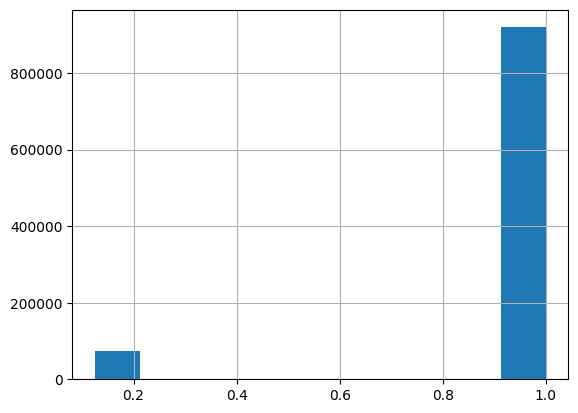

In [35]:
pred_df.score.hist()

In [26]:
pred_df[(pred_df.document==20) & (pred_df.label!=7)].head(100)

,document,token,label,score
4,20,4,0,0.1250
5,20,5,0,0.9831
6,20,6,0,0.9981
7,20,7,0,0.1250
10,20,10,0,0.1250
13,20,13,0,0.1250
15,20,15,0,0.1250
17,20,17,0,0.1250
31,20,31,0,0.1250
46,20,46,0,0.1250
